Base paper - https://arxiv.org/pdf/1707.02131.pdf


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from glob import glob
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import optim

In [2]:
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)

In [3]:
test_images_path = "../input/signature-verification-dataset/sign_data/test/"
train_images_path = "../input/signature-verification-dataset/sign_data/train/"
train_path = "../input/signature-verification-dataset/sign_data/train_data.csv"
test_path = "../input/signature-verification-dataset/sign_data/test_data.csv"

In [4]:
column_names = ["img1", "img2", "label"]
train_data = pd.read_csv(train_path, names=column_names)
test_data = pd.read_csv(test_path, names=column_names)

In [5]:
train_data.head()

,img1,img2,label
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23206 entries, 0 to 23205
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   img1    23206 non-null  object
 1   img2    23206 non-null  object
 2   label   23206 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 544.0+ KB


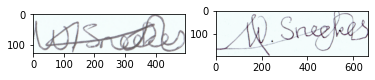

In [7]:
fig, axes = plt.subplots(1,2)
img1 = np.array(Image.open(train_images_path + "068/09_068.png"))
img2 = np.array(Image.open(train_images_path + "068_forg/03_0113068.PNG"))
axes[0].imshow(img1)
axes[1].imshow(img2)

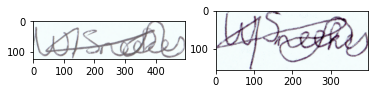

In [8]:
fig, axes = plt.subplots(1,2)
img1 = np.array(Image.open(train_images_path + "068/09_068.png"))
img2 = np.array(Image.open(train_images_path + "068_forg/01_0124068.PNG"))
axes[0].imshow(img1)
axes[1].imshow(img2)

We have images of different sizes. Need to convert to same size.

In [9]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, data, path, transform=None):
        self.data = data
        self.path = path
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img1 = Image.open(train_images_path + self.data["img1"][idx])
        img2 = Image.open(train_images_path + self.data["img2"][idx])
        label = self.data["label"][idx]
        
        # Apply image transformations
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, label

In [10]:
size = (155, 220)
resize = transform=transforms.Compose([transforms.Resize(size),
                                       transforms.ToTensor()
                                     ])
train_dataset = SiameseNetworkDataset(train_data, train_images_path, transform=resize)
test_dataset = SiameseNetworkDataset(test_data, test_images_path, transform=resize)

In [11]:
def visualize_pair(img1, img2, label):
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(np.transpose(img1.numpy(), (1, 2, 0)))
    axes[1].imshow(np.transpose(img2.numpy(), (1, 2, 0)))
    if label:
        fig.suptitle('Forged', y=0.8)
    else:
        fig.suptitle('Original', y=0.8)

In [12]:
img1.shape

(126, 497, 3)

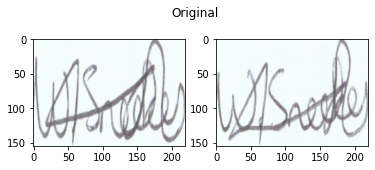

In [13]:
img1, img2, label = train_dataset[100]
visualize_pair(img1, img2, label)

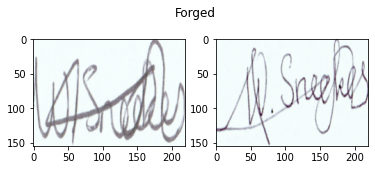

In [14]:
img1, img2, label = train_dataset[0]
visualize_pair(img1, img2, label)

### Architecture of SigNet:
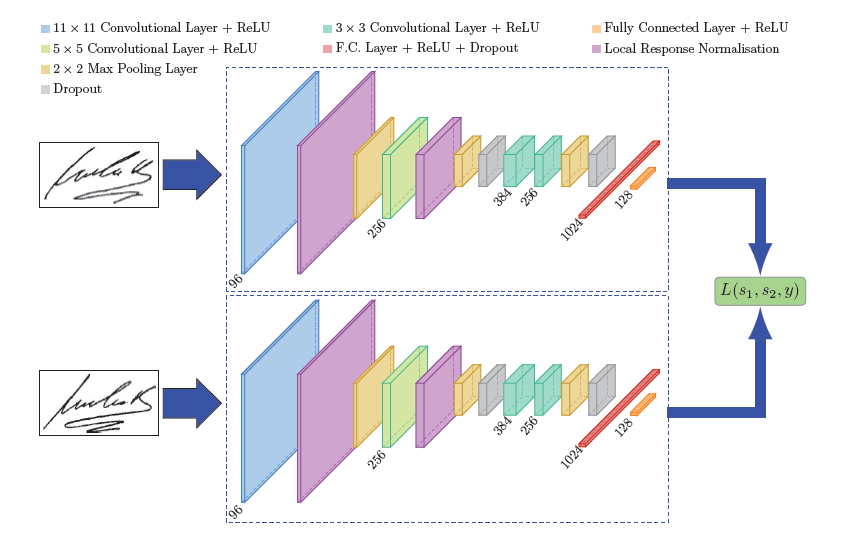
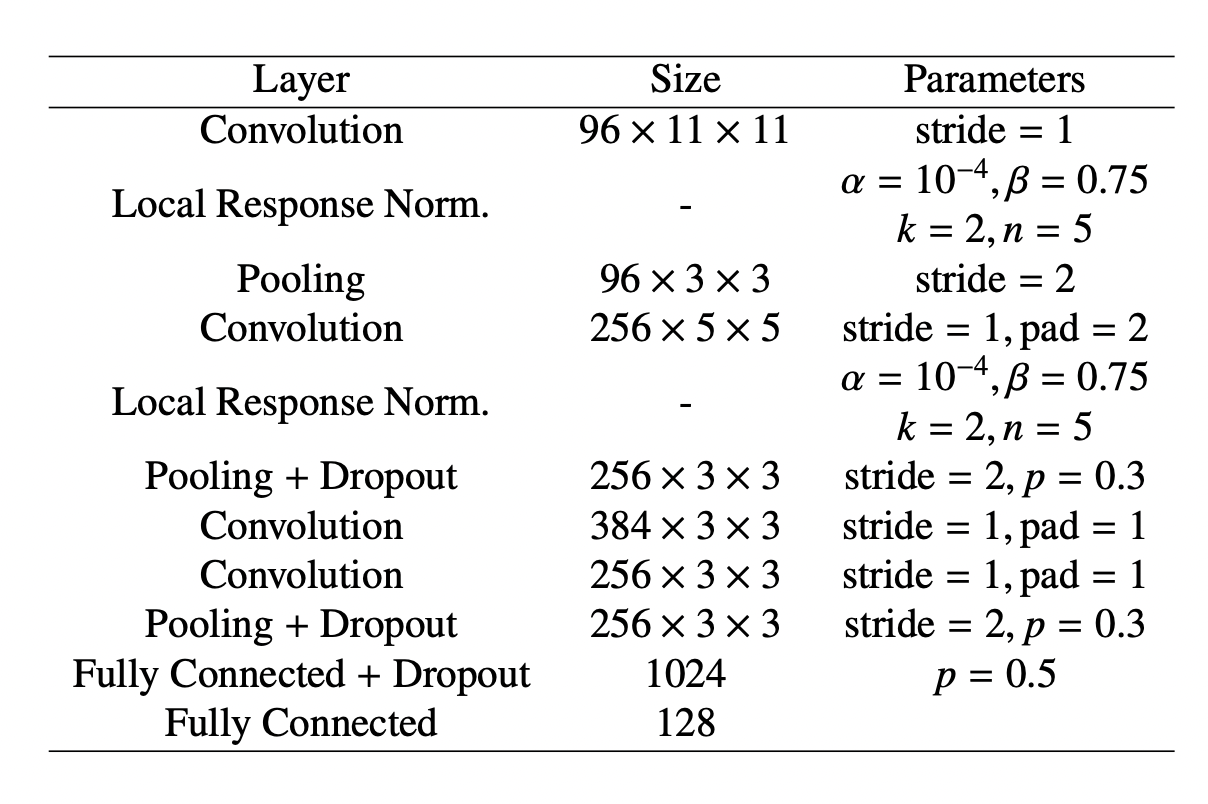

In [15]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.3, inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.3, inplace=True),
        )
        
        self.fc = nn.Sequential(
            
            nn.Linear(108800, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2)
        )
        
    def forward_once(self, image):
            image = torch.tensor(image).float()
            y = self.cnn(image)
            y = y.view(y.shape[0], -1)
            y = self.fc(y)
            return y
        
    def forward(self, img1, img2):
        y1 = self.forward_once(img1)
        y2 = self.forward_once(img2)
        
        return y1, y2
            
    

In [16]:
model = SiameseNetwork()

In [17]:
# y1, y2 = model(np.reshape(img1, (155, 220, 1)), np.reshape(img2, (155, 220, 1)))

In [18]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [19]:
Loss = ContrastiveLoss()

In [20]:
# Loss(y1, y2, label)

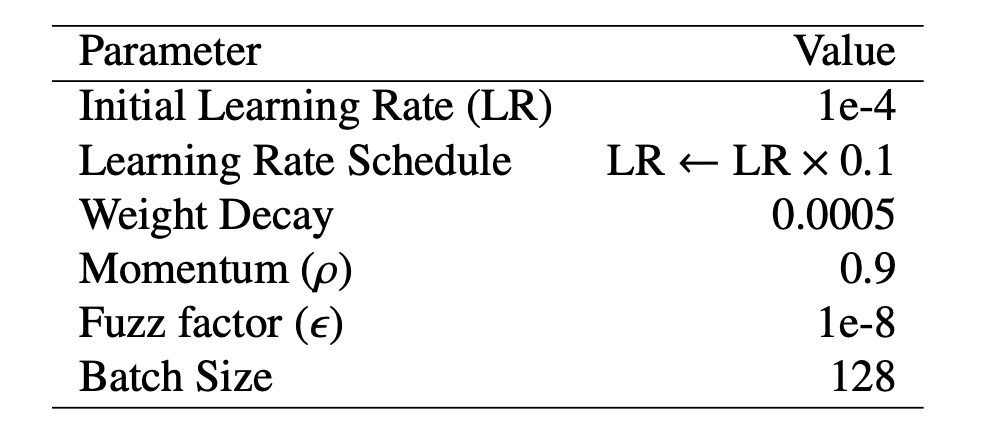

In [21]:
model = SiameseNetwork()
if torch.cuda.is_available():
    model = model.cuda()
criterion = ContrastiveLoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4, eps=1e-8, weight_decay=0.0005, momentum=0.9)
epochs = 20
# Batch size 128 leads to ram overflow
batch_size = 32

In [22]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [23]:
counter = []
loss_history = [] 
def train():
    iteration_number= 0
    
    for epoch in range(epochs):
        for i, data in enumerate(train_dataloader, 0):
            img1, img2 , label = data
#             if torch.cuda.is_available():
            img1, img2 , label = img1.cuda(), img2.cuda() , label.cuda()
            
            optimizer.zero_grad()
            y1, y2 = model(img1, img2)
            loss_contrastive = criterion(y1, y2, label)
            loss_contrastive.backward()
            optimizer.step()
            
            if i % 50 == 0:
                print("Epoch number {}\n Current loss {}\n".format(epoch, loss_contrastive.item()))
                iteration_number += 10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())

In [24]:
train()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch number 0
 Current loss 1.8693513870239258

Epoch number 0
 Current loss 1.2793010473251343

Epoch number 0
 Current loss 1.2237732410430908

Epoch number 0
 Current loss 1.3511080741882324

Epoch number 0
 Current loss 1.3486676216125488

Epoch number 0
 Current loss 1.5582735538482666

Epoch number 0
 Current loss 1.7591561079025269

Epoch number 0
 Current loss 1.6920974254608154

Epoch number 0
 Current loss 1.1634737253189087

Epoch number 0
 Current loss 1.38968026638031

Epoch number 0
 Current loss 1.4055068492889404

Epoch number 0
 Current loss 1.1525715589523315

Epoch number 0
 Current loss 1.7507749795913696

Epoch number 0
 Current loss 1.3049429655075073

Epoch number 0
 Current loss 1.2572466135025024

Epoch number 1
 Current loss 1.2921581268310547

Epoch number 1
 Current loss 1.5273427963256836

Epoch number 1
 Current loss 1.864914894104004

Epoch number 1
 Current loss 1.192234754562378

Epoch number 1
 Current loss 2.0168521404266357

Epoch number 1
 Current 

In [25]:
torch.save(model.state_dict(), "model.pt")